In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# KNN

## Titanic
Vamos a crear un modelo que prediga la probabilidad de supervivencia de los pasajeros

https://www.kaggle.com/c/titanic/data?select=train.csv

0. Importar data de training y testing. Agregarle a la tabla de testing la columna survived proveniente de la tabla gender_submission

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
resultados = pd.read_csv("gender_submission.csv")
resultados.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [3]:
test_data = test_data.merge(resultados, how = "left") # hacemos left join y añadios columna 
test_data.shape

(418, 12)

1. Buscar columnas con valores nulos y cantidad de nulos en cada una. Fijarse el porcentaje de los datos nulos que representan sobre el total.

In [4]:
train_data.isnull().sum() 
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

In [5]:
total_filas = train_data.shape[0]
print(f"La columna Age tiene un {177/total_filas*100}%")
print(f"La columna Cabin tiene un {687/total_filas*100}%")
print(f"La columna Embarked tiene un {2/total_filas*100}%")

La columna Age tiene un 19.865319865319865%
La columna Cabin tiene un 77.10437710437711%
La columna Embarked tiene un 0.22446689113355783%


2. En base al resultado anterior. ¿Cúales columnas consideran que tienen sentido completar y cuales se deberían eliminar? Eliminar la que corresponda de la tabla de test y de train.

In [6]:
train_data.drop("Cabin", axis = "columns", inplace = True)
test_data.drop("Cabin", axis = "columns", inplace = True)

3. Completar valores nulos con el criterio que considres correcto en cada una de las columnas (que tengan sentido completar). Esto debe hacerse tanto en la tabla de training como la de testing (con el mismo criterio en ambas).

   Verificar como se distribuyen los valores de cada columna con un gráfico previamente para tener más herramientas en la decisión

<Axes: xlabel='Age', ylabel='Count'>

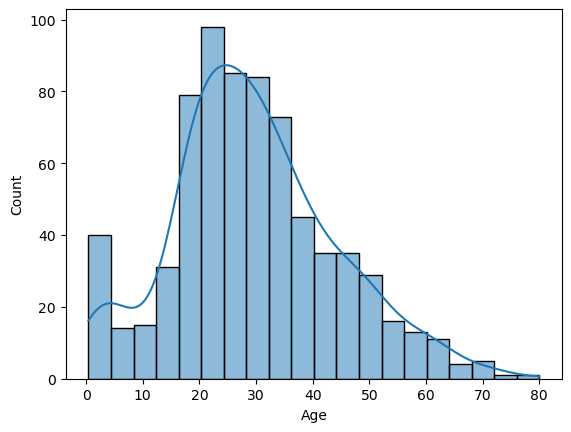

In [7]:
sns.histplot(train_data["Age"], kde = True)

In [8]:
print(train_data["Age"].median())
print(train_data["Age"].mean())

28.0
29.69911764705882


In [9]:
test_data['Age'].median()

27.0

In [10]:
mediana = train_data["Age"].median()
train_data["Age"] = train_data["Age"].fillna(mediana)

test_data["Age"] = test_data["Age"].fillna(test_data["Age"].median())

In [11]:
test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Survived       0
dtype: int64

<Axes: xlabel='Embarked', ylabel='PassengerId'>

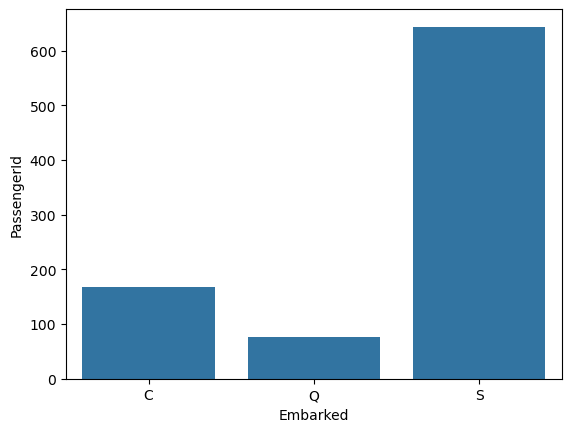

In [12]:
embarked = train_data.groupby("Embarked").agg({"PassengerId":"count"}).reset_index()

sns.barplot(data = embarked, x="Embarked", y="PassengerId")

In [13]:
train_data['Embarked'] = train_data["Embarked"].fillna(
    train_data['Embarked'].mode()
)

In [14]:
train_data['Embarked'].mode()[0]

'S'

In [15]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [16]:
test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Survived       0
dtype: int64

In [17]:
test_data.loc[test_data["Fare"].isnull(),:]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0


In [18]:
test_data.groupby('Pclass')['Fare'].mean()

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [19]:
promedio = test_data.loc[test_data["Pclass"] == 3,"Fare"].mean()

test_data["Fare"].fillna(
    promedio, 
    inplace=True
)

/var/folders/rc/n_wty2zd1nn1yx7fwtj0s5j80000gn/T/ipykernel_1425/3913868547.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data["Fare"].fillna(


4. Realizar análisis exploratorio. Graficar las personas que sobrevivieron por:
    - Clase (Pclass)
    - Sexo (Sex)
    - Costo de boleto (Fare)

<Axes: xlabel='Pclass', ylabel='count'>

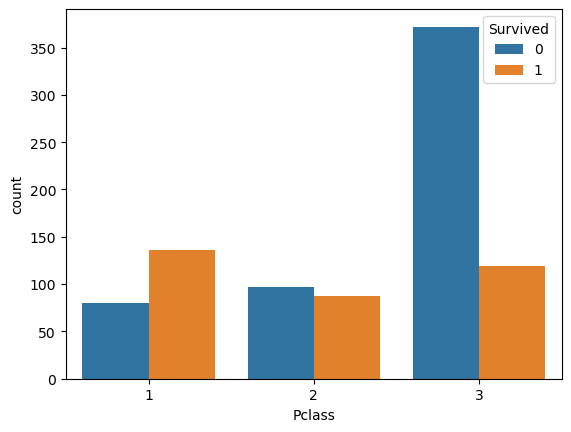

In [20]:
sns.countplot(data = train_data, x = "Pclass", hue = "Survived")

<Axes: xlabel='Sex', ylabel='count'>

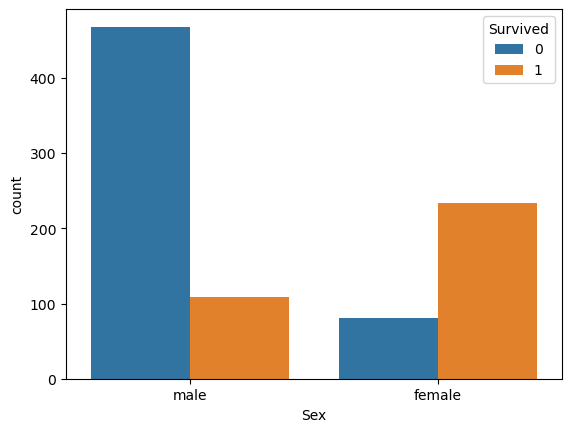

In [21]:
sns.countplot(data = train_data, x = "Sex", hue = "Survived")

(0.0, 200.0)

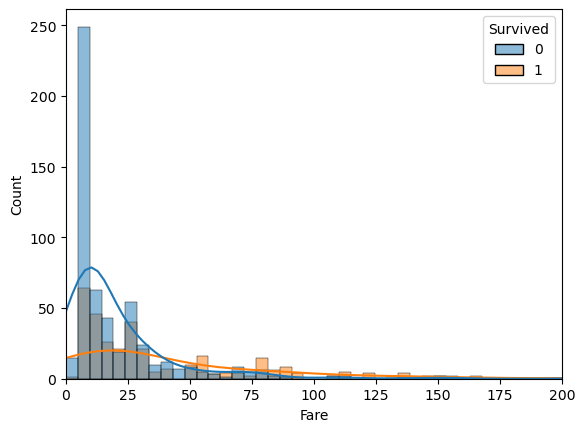

In [22]:
sns.histplot(x=train_data["Fare"], hue=train_data["Survived"],kde =True)
plt.xlim((0,200))

5. Verificar columnas del DataFrame e identificar sobre cuales se deberían generar variables dummies.
   Generar columnas de dummies sobre "Pclass","Embarked" y "Sex". Aplicar cambios en training y testing

In [23]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1


In [24]:
test_data = pd.get_dummies(
    test_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

train_data = pd.get_dummies(
    train_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

In [25]:
test_data.head() 

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Survived,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,False,True,True,False,True
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,1,False,True,False,True,False
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,True,False,True,False,True
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,False,True,False,True,True
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,1,False,True,False,True,False


6. Eliminar columnas del dataset que considere que no suman al modelo. Hacerlo en testing y training

In [26]:
train_data.drop('PassengerId', axis=1, inplace=True)
train_data.drop('Name', axis=1, inplace=True)
train_data.drop('Ticket', axis=1, inplace=True)

test_data.drop('PassengerId', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)
test_data.drop('Ticket', axis=1, inplace=True)

7. Agregar una columna llamada "IsMinor" que sea 1 en caso de tener 16 años o menos y 0 en caso contrario. Hacerlo para testing y training

In [27]:
train_data['IsMinor']=np.where(train_data['Age']<=16, 1, 0)
test_data['IsMinor']=np.where(test_data['Age']<=16, 1, 0)

In [28]:
train_data.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S', 'Sex_male', 'IsMinor'],
      dtype='object')

8. Ajustar modelo considerando todas las variables del dataset de testing.

In [29]:
from sklearn import neighbors

In [30]:
X_train = train_data.loc[:,train_data.columns != "Survived"]
y_train = train_data["Survived"]

In [31]:
k = 5
modelo = neighbors.KNeighborsClassifier(n_neighbors=k)
modelo.fit(X_train,y_train)

KNeighborsClassifier()

9. Validar el modelo con datos de testing, agregar columna con cluster a test_data

In [32]:
test_data.head()

,Age,SibSp,Parch,Fare,Survived,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,34.5,0,0,7.8292,0,False,True,True,False,True,0
1,47.0,1,0,7.0000,1,False,True,False,True,False,0
2,62.0,0,0,9.6875,0,True,False,True,False,True,0
3,27.0,0,0,8.6625,0,False,True,False,True,True,0
4,22.0,1,1,12.2875,1,False,True,False,True,False,0


In [33]:
X_test = test_data.loc[:,test_data.columns != "Survived"]
y_real = test_data["Survived"]

test_data["y_pred"] = modelo.predict(X_test) # si no se aclara nada, por defecto el threshold es 0.5
test_data.head

<bound method NDFrame.head of       Age  SibSp  Parch      Fare  Survived  Pclass_2  Pclass_3  Embarked_Q  \
0    34.5      0      0    7.8292         0     False      True        True   
1    47.0      1      0    7.0000         1     False      True       False   
2    62.0      0      0    9.6875         0      True     False        True   
3    27.0      0      0    8.6625         0     False      True       False   
4    22.0      1      1   12.2875         1     False      True       False   
..    ...    ...    ...       ...       ...       ...       ...         ...   
413  27.0      0      0    8.0500         0     False      True       False   
414  39.0      0      0  108.9000         1     False     False       False   
415  38.5      0      0    7.2500         0     False      True       False   
416  27.0      0      0    8.0500         0     False      True       False   
417  27.0      1      1   22.3583         0     False      True       False   

     Embarked_S  Sex_

10. Calcular matriz de confusión

11. Calcular Accuracy

12. Calcular sensibilidad

13. Calcular especificidad